In [1]:
%load_ext autoreload
%autoreload 2

import src.simulation.water_demands as wd
from pathlib import Path
import warnings 
warnings.filterwarnings("ignore")
Path.cwd()

2024-07-07 02:07:44.634 | INFO     | src.const:get_project_root:20 - PROJECT_ROOT set to /Users/adamzh0u/315_RL/cege_test


PosixPath('/Users/adamzh0u/315_RL/cege_test')

## test

In [12]:
water_demand[100:].min(), water_demand[100:].max()

(-0.6194127159474498, 0.4043631408564916)

In [7]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
n_points = 10000
p, d, q = 5, 2, 5
model = ARIMA(np.random.randn(n_points), order=(p, d, q))
model_fit = model.fit()
water_demand = model_fit.predict(start=0, end=n_points-1)

In [3]:
model_fit.summary()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                10000
Model:                 ARIMA(5, 2, 5)   Log Likelihood              -14232.106
Date:                Sun, 07 Jul 2024   AIC                          28486.213
Time:                        02:07:49   BIC                          28565.524
Sample:                             0   HQIC                         28513.059
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.6938      0.011   -247.323      0.000      -2.715      -2.672
ar.L2         -2.6526      0.030    -89.198      0.000      -2.711      -2.594
ar.L3         -0.9266      0.038    -24.159      0.0

## genertate data 

In [ ]:
- seed > 100  leak_increase_range=(5, 10)

In [25]:
# generate 10 independent water demands data 
# for seed in range(50):
for seed in [142]:
    num_leaks = 12
    df = wd.simulation(seed, num_leaks)
    wd.save(df, seed, num_leaks)

Data saved successfully Data_water_demand_with_leaks_142_12.txt


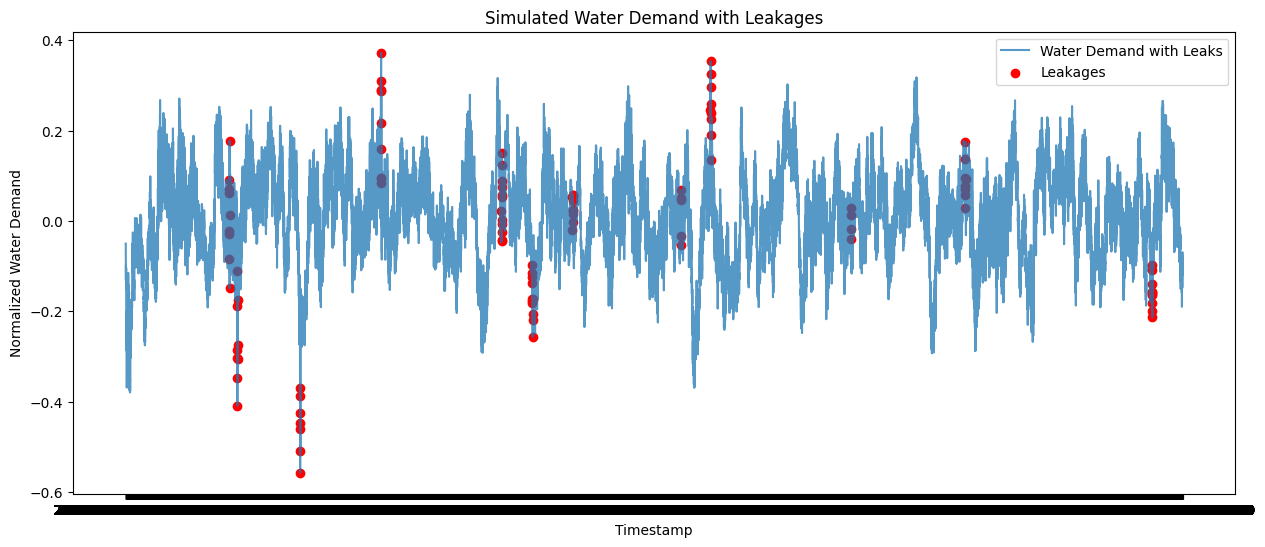

In [5]:
seed = 50
df = wd.load(seed, num_leaks)
wd.plot(df)